# Exploratory Data Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob

import noisereduce as nr

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [2]:
def get_max_frequency(file_path):
    """Get max frequency of a .wav file"""
    y, sr = librosa.load(file_path, sr=None)
    # Compute the short-time Fourier transform
    D = np.abs(librosa.stft(y))
    # Compute the frequency range
    freqs = librosa.fft_frequencies(sr=160000) # Hardcoded frequency
    # Compute the average power spectral density
    avg_psd = np.mean(librosa.amplitude_to_db(D, ref=np.max), axis=1)
    # Find the frequency with the maximum power spectral density
    max_freq = freqs[np.argmax(avg_psd)]
    return max_freq

def calculate_average(frequency: float):
    # Calculate the average of the highest frequencies
    avg_max_freq = np.mean(frequency)
    print(f"Average highest frequency: {avg_max_freq} Hz")

    # Suggest a sample rate (double the average highest frequency, rounded up to nearest standard rate)
    suggested_sample_rate = int(np.ceil(avg_max_freq * 2 / 1000) * 1000)
    print(f"Suggested sample rate: {suggested_sample_rate} Hz")


## Local file path

### Only use 6db sample
* Experiment with using 0db or -6dB samples as we do not have baseline background noise

In [3]:

# audio_files = glob('/Users/jaimacabangon/Downloads/slider_0db/*/*/*.wav')
# audio_files_minus_6 = glob('/Users/jaimacabangon/Downloads/slider_-6db/*/*/*.wav')
audio_files = glob('/Users/jaimacabangon/Downloads/slider_6db/*/*/*.wav')
# audio_files_fan_0 = glob('/Users/jaimacabangon/Downloads/fan_0db/*/*/*.wav')
# audio_files_fan_minus_6 = glob('/Users/jaimacabangon/Downloads/fan_-6db/*/*/*.wav')
audio_files_fan_6 = glob('/Users/jaimacabangon/Downloads/fan_6db/*/*/*.wav')
# audio_files_pump_0 = glob('/Users/jaimacabangon/Downloads/pump_0db/*/*/*.wav')
# audio_files_pump_minus_6 = glob('/Users/jaimacabangon/Downloads/pump_-6db/*/*/*.wav')
audio_files_pump_6 = glob('/Users/jaimacabangon/Downloads/pump_6db/*/*/*.wav')
# audio_files_valve_0 = glob('/Users/jaimacabangon/Downloads/valve_0db/*/*/*.wav')
# audio_files_valve_minus_6 = glob('/Users/jaimacabangon/Downloads/valve_-6db/*/*/*.wav')
audio_files_valve_6 = glob('/Users/jaimacabangon/Downloads/valve_6db/*/*/*.wav')


# audio_files.extend(audio_files_6)
# audio_files.extend(audio_files_minus_6)


# audio_files.extend(audio_files_fan_0)
# audio_files.extend(audio_files_fan_minus_6)
audio_files.extend(audio_files_fan_6)

# audio_files.extend(audio_files_pump_0)
# audio_files.extend(audio_files_pump_minus_6)
audio_files.extend(audio_files_pump_6)

# audio_files.extend(audio_files_valve_0)
# audio_files.extend(audio_files_valve_minus_6)
audio_files.extend(audio_files_valve_6)


In [4]:
print(len(audio_files), audio_files[0])

18019 /Users/jaimacabangon/Downloads/slider_6db/id_00/abnormal/00000059.wav


In [5]:
# Abnormal sound
ipd.Audio(audio_files[0])

#### Y = Raw Value
#### Sample Rate 16khz 

In [6]:
y, sample_rate = librosa.load(audio_files[0], sr=None)
print(f'Raw data (10): {y[:10]}')
print(f'Raw data shape: {y.shape}')
print(f'Sample Rate: {sample_rate}')

Raw data (10): [ 1.1634827e-03  1.2207031e-04 -4.6539307e-04 -1.4495850e-04
 -1.4114380e-04  4.9591064e-05  7.5912476e-04  1.4114380e-03
  2.3269653e-03  3.4446716e-03]
Raw data shape: (160000,)
Sample Rate: 16000


### Raw Audio sample (No Fourier Transform)

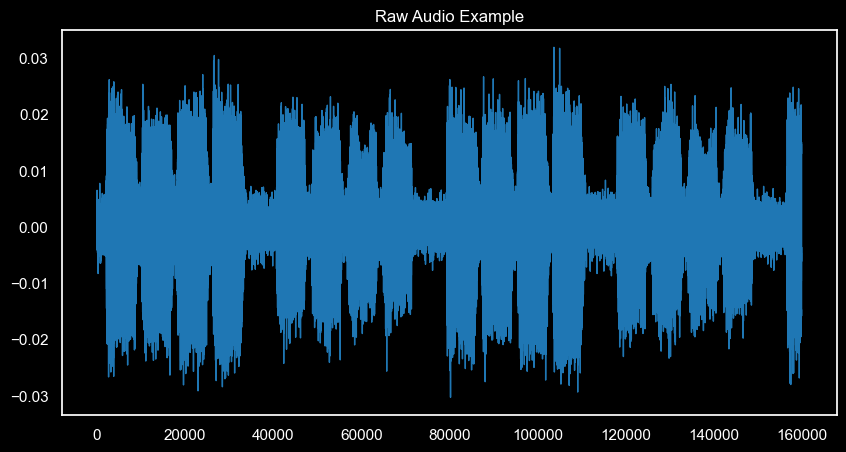

In [7]:
plt.style.use('dark_background')

pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                 color=color_pal[0])
plt.show()

# Spectrogram sample
* Generate a mel one

# Spectrogram sample
* log spectogram 

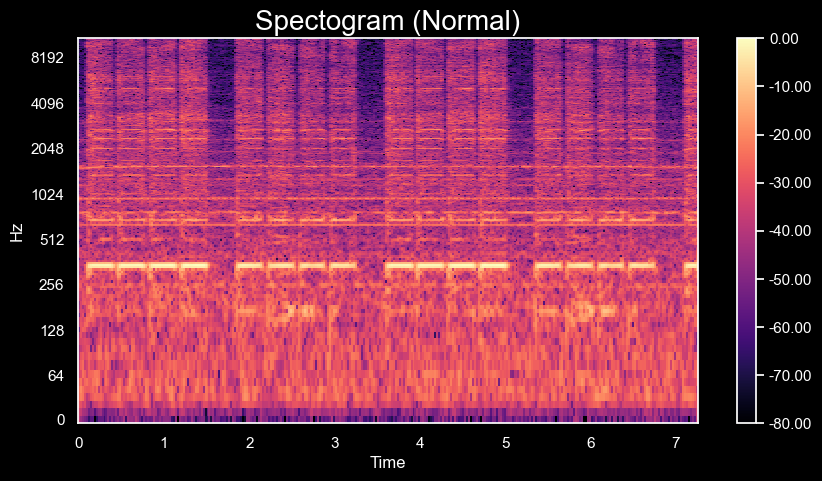

In [8]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram (Normal)', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

### Zoomed in view 100000 <-> 150000

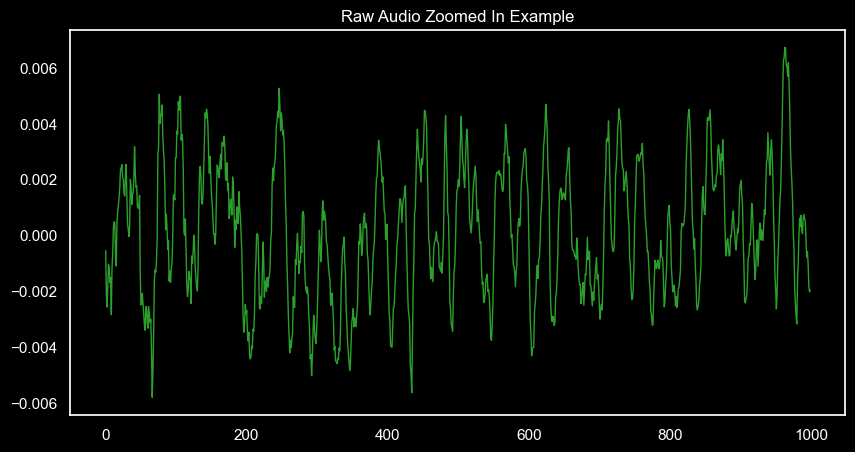

In [9]:
plt.style.use('dark_background')


pd.Series(y[149000:150000]).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Zoomed In Example',
                 color=color_pal[2])
plt.show()

# Create initial Dataframe
* Split string for data frame creation
* Initial dataframe will include:
    * Machine type (slider, valve, fan, pump)
    * unique machine ID (id_NN)
    * wav file name
    * Sound type (normal vs abnormal)
    * Raw data (raw audio data)

In [10]:
test = audio_files[0]
new = test.split('/')
print(new)

['', 'Users', 'jaimacabangon', 'Downloads', 'slider_6db', 'id_00', 'abnormal', '00000059.wav']


In [11]:
raw_data_list = [] 
sample_rate_list = []
sound_source_list = [] 
binary_classification_list = [] 
wav_file_list = [] 
name_classification_list = []

for audio_file in audio_files:
    split_string = str(audio_file).split('/')
    sound_source = split_string[4]
    name_classification = sound_source.split("_")[0]
    binary_classification = split_string[6]
    wav_file = split_string[7]
    raw_data, sample_rate = librosa.load(audio_file, sr=None)
    sound_source_list.append(sound_source)
    binary_classification_list.append(binary_classification)
    wav_file_list.append(wav_file)
    raw_data_list.append(raw_data)
    sample_rate_list.append(sample_rate)
    name_classification_list.append(name_classification)


    

### 50k samples average time to DF ~5mins

In [12]:
df = pd.DataFrame(columns=["Sound Source","Machine Type", "Classification", ".wav File", "Sample Rate", "Raw Data"])

In [13]:
df["Sound Source"] = sound_source_list
df["Machine Type"] = name_classification_list # label for machine type 
df["Classification"] = binary_classification_list # label for 0 or 1 (normal vs abnormal)
df[".wav File"] = wav_file_list
df["Sample Rate"] = sample_rate_list
df["Raw Data"] = raw_data_list

In [14]:
df

Sound Source Machine Type Classification     .wav File  Sample Rate  \
0       slider_6db       slider       abnormal  00000059.wav        16000   
1       slider_6db       slider       abnormal  00000071.wav        16000   
2       slider_6db       slider       abnormal  00000065.wav        16000   
3       slider_6db       slider       abnormal  00000273.wav        16000   
4       slider_6db       slider       abnormal  00000267.wav        16000   
...            ...          ...            ...           ...          ...   
18014    valve_6db        valve         normal  00000083.wav        16000   
18015    valve_6db        valve         normal  00000097.wav        16000   
18016    valve_6db        valve         normal  00000068.wav        16000   
18017    valve_6db        valve         normal  00000040.wav        16000   
18018    valve_6db        valve         normal  00000054.wav        16000   

                                                Raw Data  
0      [0.0011634827, 0.00012207031, -0.00046539307, ...  
1      [0.004940033, 0.0047073364, 0.0077323914, -0.0...  
2      [0.0025291443, 0.002922058, 0.0031700134, 0.00...  
3      [-0.007286072, -0.0062065125, -0.0077590942, -...  
4      [-0.0026016235, -0.0023345947, -0.002998352, -...  
...                                                  ...  
18014  [-0.0015220642, -0.0024032593, -0.0027389526, ...  
18015  [-0.0033035278, -0.0030288696, -0.0026435852, ...  
18016  [-0.0005912781, -1.9073486e-05, 0.00062179565,...  
18017  [-0.00061035156, -0.0008201599, -0.00074768066...  
18018  [-0.0022010803, -0.0014953613, -0.00020980835,...  

[18019 rows x 6 columns]

# Calculate mean/std of raw audio data 

In [15]:
df['Mean'] = df['Raw Data'].apply(np.mean)
df['Standard Deviation'] = df['Raw Data'].apply(np.std)
# df['Max Value'] = df['Raw Data'].apply(np.max)
# df['Min Value'] = df['Raw Data'].apply(np.min) # comment out to reduce time

In [16]:
print(df["Classification"].value_counts(), "\n")
print(f'Raw data shape: {y.shape}')
df["Sound Source"].value_counts()

Classification
normal      14719
abnormal     3300
Name: count, dtype: int64 

Raw data shape: (160000,)


Sound Source
fan_6db       5550
pump_6db      4205
valve_6db     4170
slider_6db    4094
Name: count, dtype: int64

Audio distribution
* normal    ->  44157
* abnormal   -> 9900

### Data taken at consistent sample rate of 16khz
### Abnormal vs normal samples are not 50:50
#### Normal % = 81.7% 
#### Abnormal % =18.3%


### Given Sample rate is consistent, reducing sample rate is not recommended as we could lose audio quality. 

In [17]:
df["Classification"] == "abnormal"

0         True
1         True
2         True
3         True
4         True
         ...  
18014    False
18015    False
18016    False
18017    False
18018    False
Name: Classification, Length: 18019, dtype: bool

# Normal vs Markdown visualizations

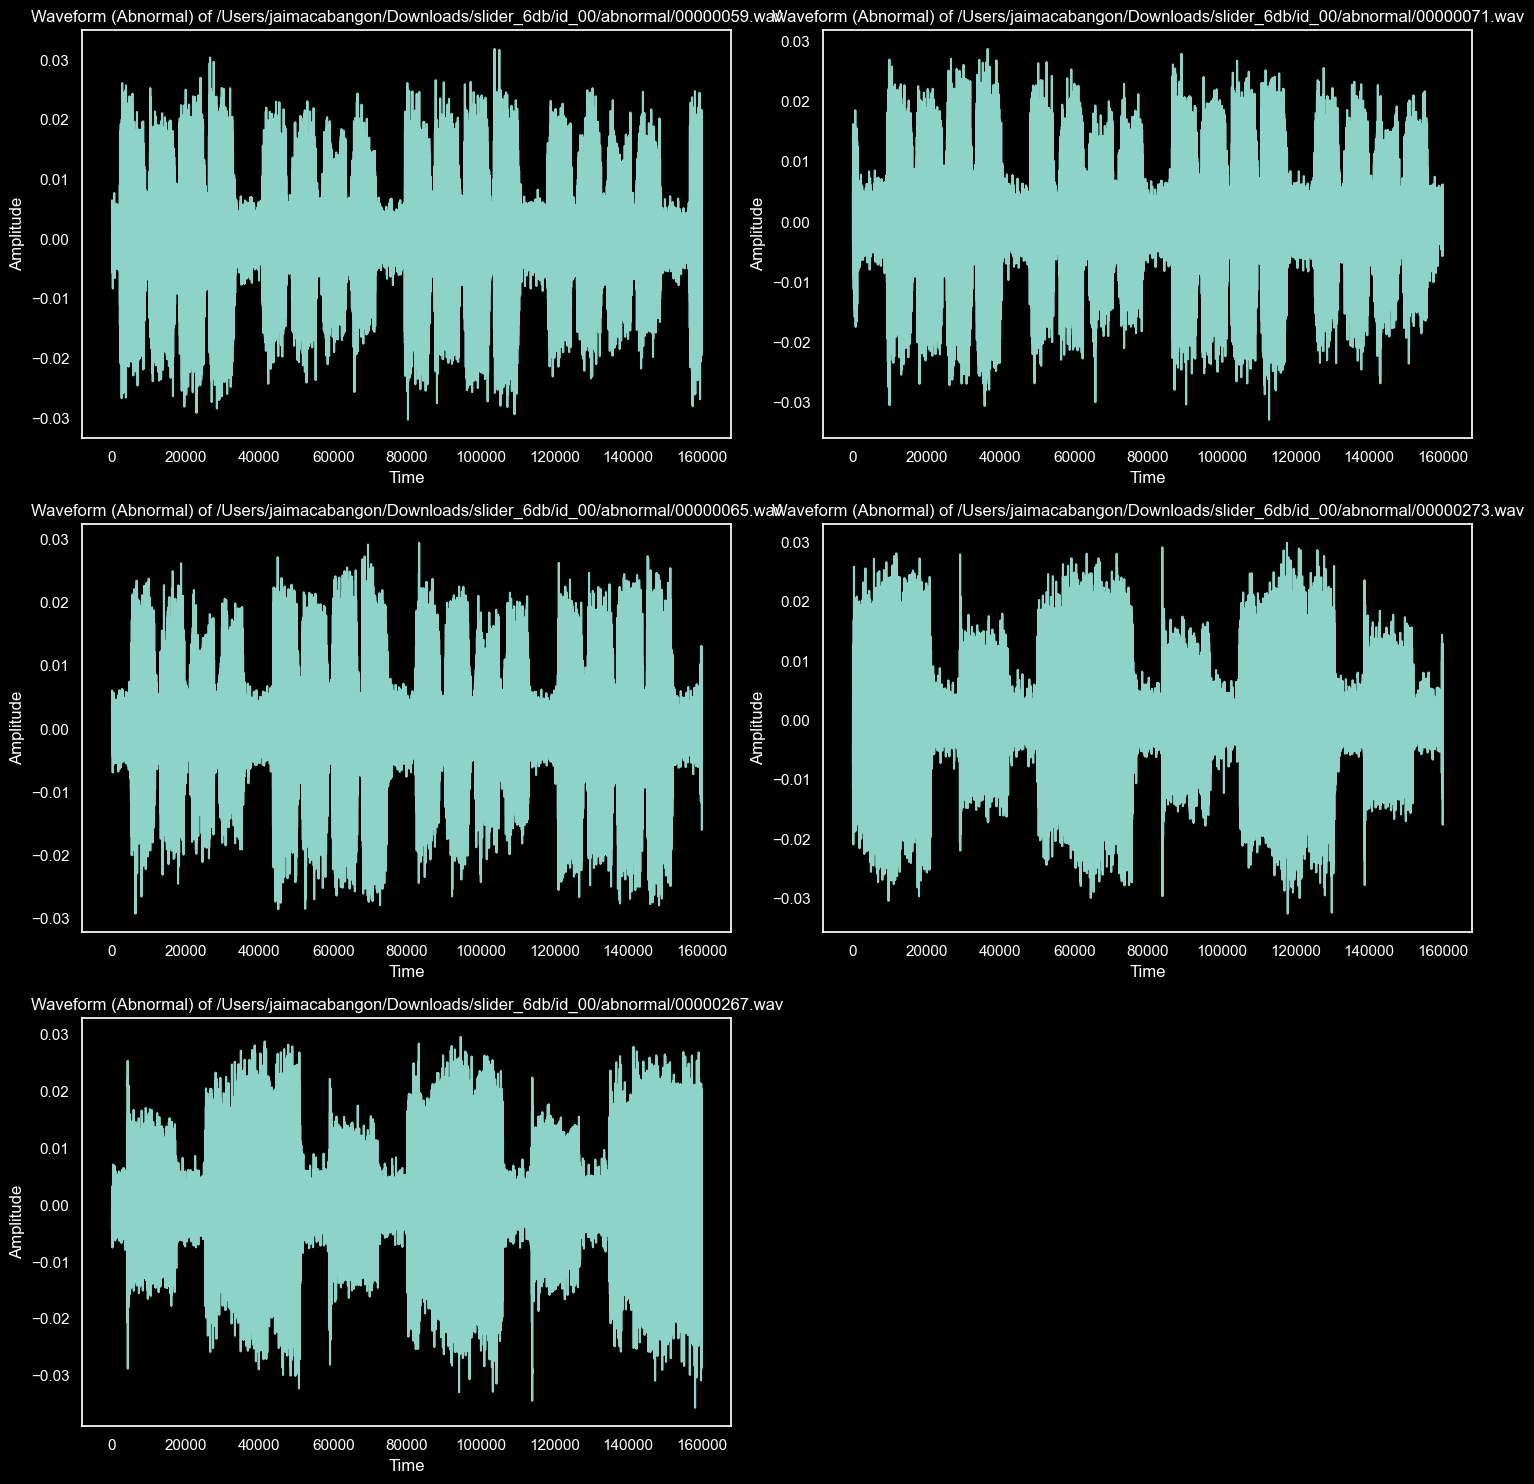

In [18]:
# Number of audio files
num_files = len(audio_files[0:5])

# Calculate the number of rows and columns for subplots
rows = (num_files + 1) // 2
cols = 2

plt.style.use('dark_background')

# Create a figure with the appropriate number of subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Iterate over the audio files and plot each one
for i, file in enumerate(audio_files[0:5]):
    # Load the audio file
    y, sample_rate = librosa.load(file, sr=None)
    
    # Plot the waveform
    axs[i].plot(y)
    axs[i].set_title(f'Waveform (Abnormal) of {file}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Amplitude')

# Hide any empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.show()

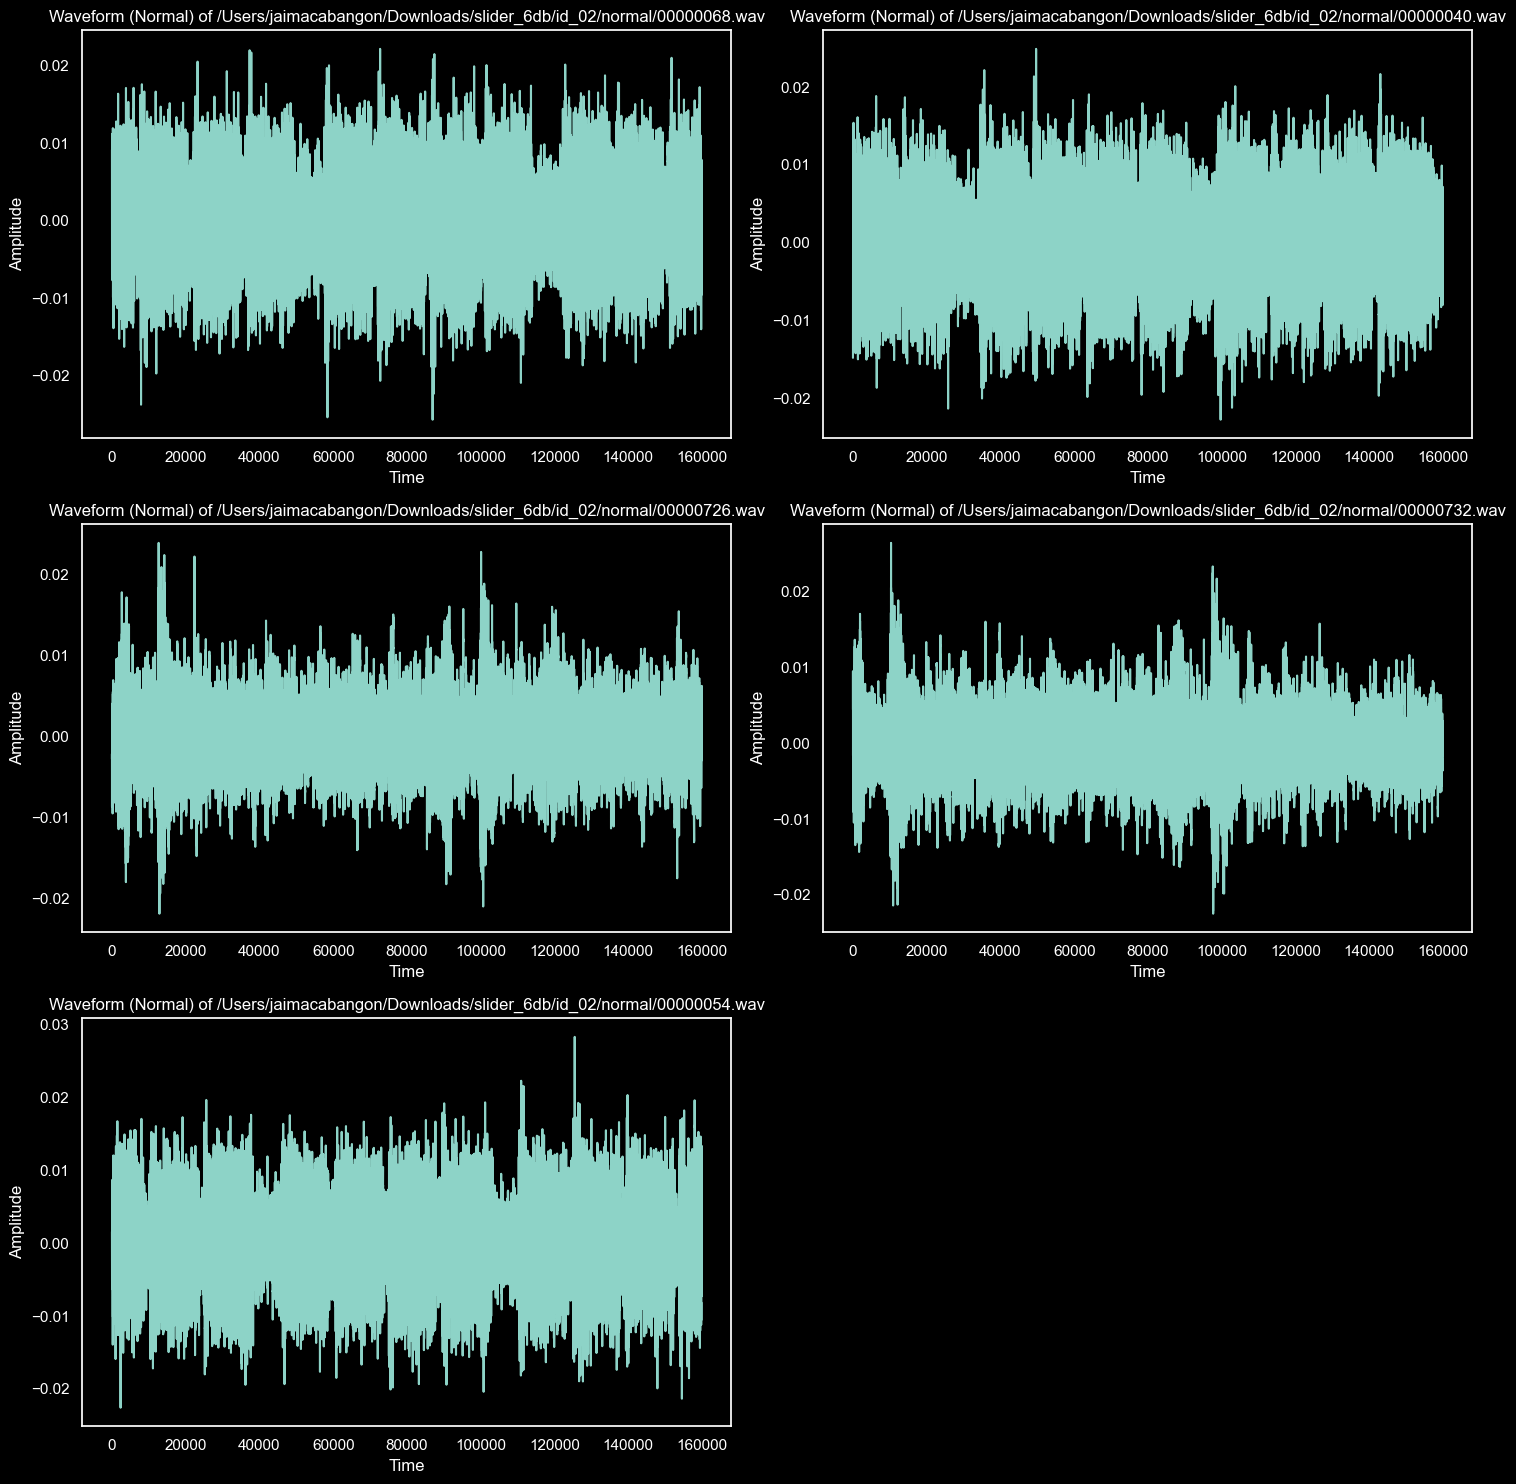

In [19]:
# Number of audio files
num_files = len(audio_files[4089:4094])

# Calculate the number of rows and columns for subplots
rows = (num_files + 1) // 2
cols = 2

# Create a figure with the appropriate number of subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten the axs array for easier iteration
axs = axs.flatten()
plt.style.use('dark_background')


# Iterate over the audio files and plot each one
for i, file in enumerate(audio_files[4089:4094]):
    # Load the audio file
    y, sample_rate = librosa.load(file, sr=None)
    
    # Plot the waveform
    axs[i].plot(y)
    axs[i].set_title(f'Waveform (Normal) of {file}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Amplitude')

# Hide any empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.show()

# RMS AND ZCR Calculations

In [20]:
def calculate_rms(signal):
    """Calculate RMS power of the signal."""
    return np.sqrt(np.mean(np.square(signal)))

def calculate_zero_crossing_rate(signal):
    """Calculate zero-crossing rate of the signal."""
    return np.mean(librosa.zero_crossings(signal, pad=False))

In [21]:
df.head()

Sound Source Machine Type Classification     .wav File  Sample Rate  \
0   slider_6db       slider       abnormal  00000059.wav        16000   
1   slider_6db       slider       abnormal  00000071.wav        16000   
2   slider_6db       slider       abnormal  00000065.wav        16000   
3   slider_6db       slider       abnormal  00000273.wav        16000   
4   slider_6db       slider       abnormal  00000267.wav        16000   

                                            Raw Data          Mean  \
0  [0.0011634827, 0.00012207031, -0.00046539307, ... -8.175373e-08   
1  [0.004940033, 0.0047073364, 0.0077323914, -0.0...  1.081657e-06   
2  [0.0025291443, 0.002922058, 0.0031700134, 0.00...  4.863978e-07   
3  [-0.007286072, -0.0062065125, -0.0077590942, -... -3.108263e-07   
4  [-0.0026016235, -0.0023345947, -0.002998352, -... -5.193234e-07   

   Standard Deviation  
0            0.007344  
1            0.007332  
2            0.007305  
3            0.007621  
4            0.007549

In [22]:
df["RMS"] = df["Raw Data"].apply(calculate_rms)
# df["ZCR"] = df["Raw Data"].apply(calculate_zero_crossing_rate)

# Total distribution of RMS/ZCR calculation 

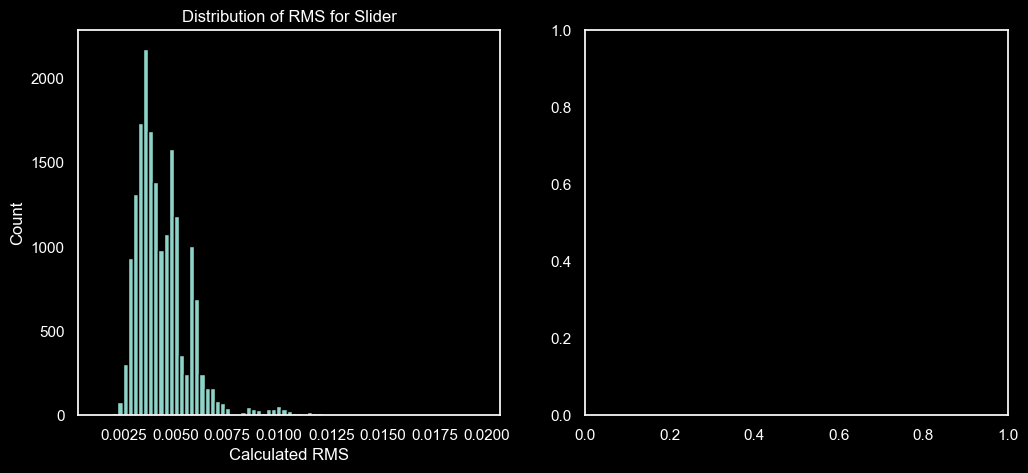

In [23]:
# Create a histogram with matplotlib
# plt.hist(df['RMS'], bins=75, edgecolor='black')
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plt.style.use('dark_background')

# # # Customize the plot
# # plt.xlabel('RMS')
# # plt.ylabel('Count')
# plt.title('Distribution of RMS for 0db Slider')

axs[0].hist(df['RMS'], bins=75, edgecolor='black')
axs[0].set_title('Distribution of RMS for Slider')
axs[0].set_xlabel('Calculated RMS')
axs[0].set_ylabel('Count')

# Histogram for column2
# axs[1].hist(df['ZCR'], bins=75, edgecolor='black')
# axs[1].set_title('Distribution of ZCR for Slider')
# axs[1].set_xlabel('Calculated ZCR')
# axs[1].set_ylabel('Count')


# Show the plot
plt.show()

### Breakdown Dataset 
* Used to visually see distribution of dataset

In [24]:
# slider_0db     4094
# slider_-6db    4094

normal_classification = df['Classification'] == 'normal'
abnormal_classification = df['Classification'] == 'abnormal'

# source_0_db = df['Sound Source'] == 'slider_0db'
# source_minus_6_db = df['Sound Source'] == 'slider_-6db'
source_6_db = df['Sound Source'] == 'slider_6db'


# # 0dB filter
# normal_filtered_df_0_db = df[normal_classification & source_0_db]
# abnormal_filtered_df_0_db = df[abnormal_classification & source_0_db]

# # -6dB filter
# normal_filtered_df_minus_6_db = df[normal_classification & source_minus_6_db]
# abnormal_filtered_df_minus_6_db = df[abnormal_classification & source_minus_6_db]


# 6dB filter
normal_filtered_df_6_db = df[normal_classification & source_6_db]
abnormal_filtered_df_6_db = df[abnormal_classification & source_6_db]

# Normal sound RMS/ZCR distribution
## Indicates lower calculated RMS values most of the samples are around the .0050 -> .0060
### Have to be careful 

# Normal sound distribution (-6dB,0dB)

NameError: name 'normal_filtered_df_minus_6_db' is not defined

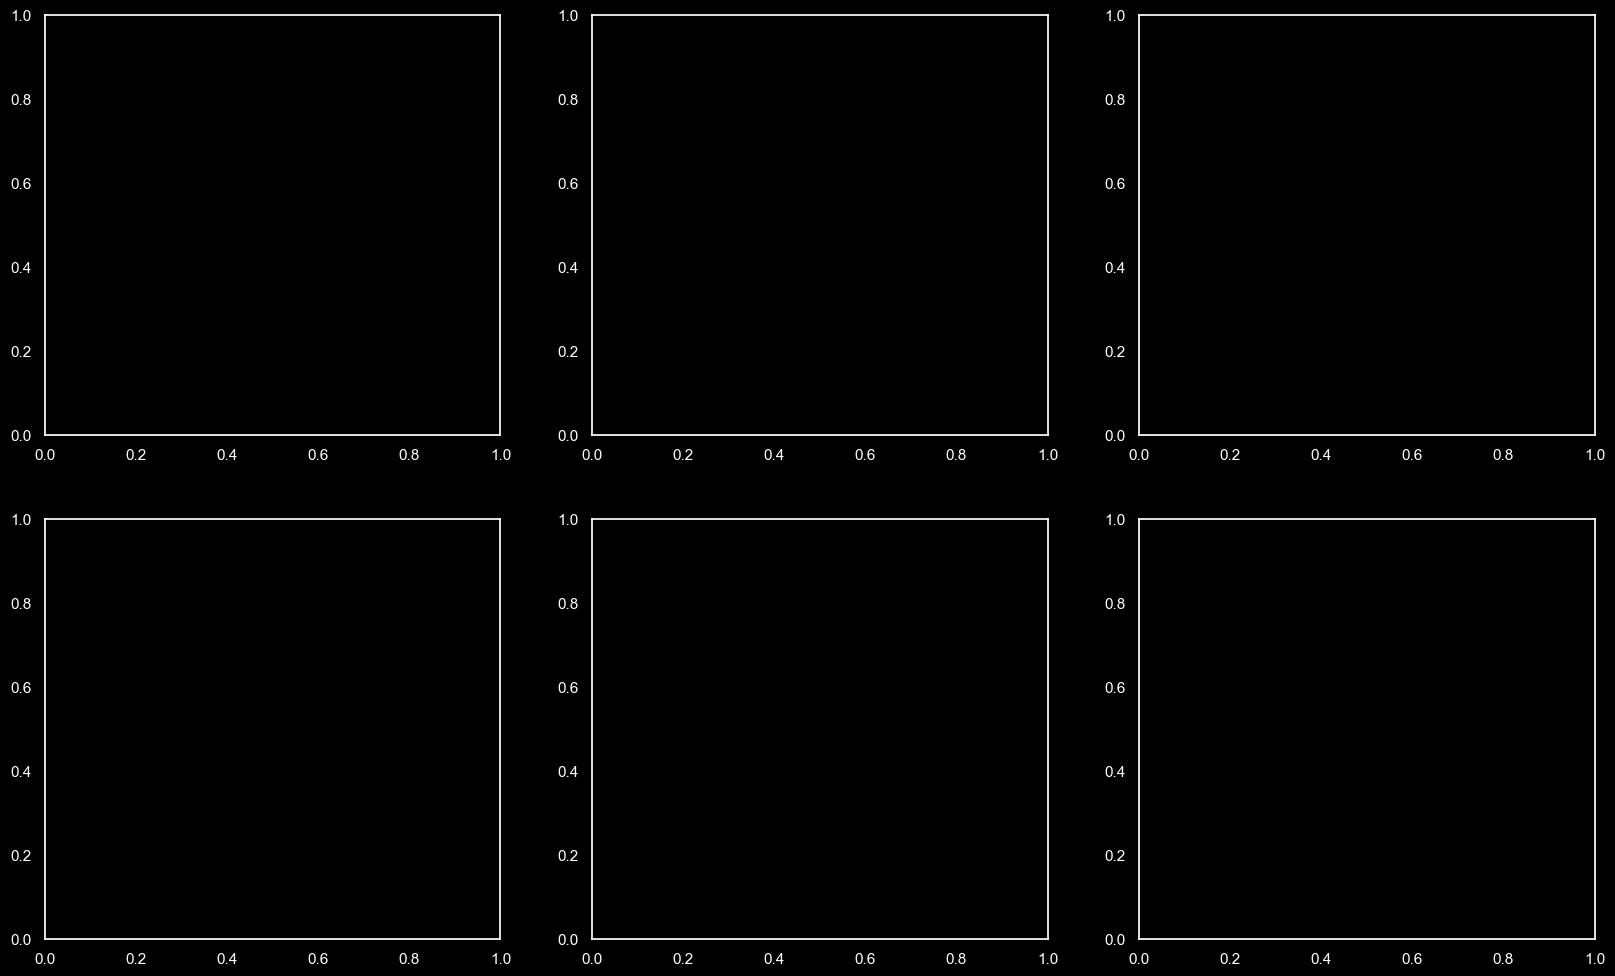

In [25]:
# fig, axs = plt.subplots(2, 3, figsize=(20, 12))

# plt.style.use('dark_background')


# axs[0,0].hist(normal_filtered_df_minus_6_db['RMS'], bins=50, edgecolor='black')
# axs[0,0].set_title('Distribution of RMS (Normal Sound) for -6dB Slider')
# axs[0,0].set_xlabel('Calculated RMS')
# axs[0,0].set_ylabel('Count')


# axs[0,1].hist(normal_filtered_df_0_db['RMS'], bins=50, edgecolor='black')
# axs[0,1].set_title('Distribution of RMS (Normal Sound) for 0dB Slider')
# axs[0,1].set_xlabel('Calculated RMS')
# axs[0,1].set_ylabel('Count')

# axs[0,2].hist(normal_filtered_df_6_db['RMS'], bins=50, edgecolor='black')
# axs[0,2].set_title('Distribution of RMS (Normal Sound) for 6dB Slider')
# axs[0,2].set_xlabel('Calculated RMS')
# axs[0,2].set_ylabel('Count')


# # Histogram for column2
# axs[1,0].hist(normal_filtered_df_minus_6_db['ZCR'], bins=50, edgecolor='black')
# axs[1,0].set_title('Distribution of ZCR (Normal Sound) for -6db Slider')
# axs[1,0].set_xlabel('Calculated ZCR')
# axs[1,0].set_ylabel('Count')


# # Histogram for column2
# axs[1,1].hist(normal_filtered_df_0_db['ZCR'], bins=50, edgecolor='black')
# axs[1,1].set_title('Distribution of ZCR (Normal Sound) for 0dB Slider')
# axs[1,1].set_xlabel('Calculated ZCR')
# axs[1,1].set_ylabel('Count')



# # Histogram for column2
# axs[1,2].hist(normal_filtered_df_6_db['ZCR'], bins=50, edgecolor='black')
# axs[1,2].set_title('Distribution of ZCR (Normal Sound) for -6db Slider')
# axs[1,2].set_xlabel('Calculated ZCR')
# axs[1,2].set_ylabel('Count')



# # Show the plot
# plt.show()

In [ ]:
# normal_filtered_df_0_db.describe()

In [ ]:
# normal_filtered_df_minus_6_db.describe()

In [ ]:
normal_filtered_df_6_db.describe()

# Abnormal sound RMS/ZCR distribution

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 12))

plt.style.use('dark_background')

axs[0,0].hist(abnormal_filtered_df_minus_6_db['RMS'], bins=50, edgecolor='black')
axs[0,0].set_title('Distribution of RMS (Abnormal Sound) for -6dB Slider')
axs[0,0].set_xlabel('Calculated RMS')
axs[0,0].set_ylabel('Count')

axs[0,1].hist(abnormal_filtered_df_0_db['RMS'], bins=50, edgecolor='black')
axs[0,1].set_title('Distribution of RMS (Abnormal Sound) for 0dB Slider')
axs[0,1].set_xlabel('Calculated RMS')
axs[0,1].set_ylabel('Count')

axs[0,2].hist(abnormal_filtered_df_6_db['RMS'], bins=50, edgecolor='black')
axs[0,2].set_title('Distribution of RMS (Abnormal Sound) for 6dB Slider')
axs[0,2].set_xlabel('Calculated RMS')
axs[0,2].set_ylabel('Count')


axs[1,0].hist(abnormal_filtered_df_minus_6_db['ZCR'], bins=50, edgecolor='black')
axs[1,0].set_title('Distribution of ZCR (Abnormal Sound) for -6dB Slider')
axs[1,0].set_xlabel('Calculated ZCR')
axs[1,0].set_ylabel('Count')


# Histogram for column2
axs[1,1].hist(abnormal_filtered_df_0_db['ZCR'], bins=50, edgecolor='black')
axs[1,1].set_title('Distribution of ZCR (Abnormal Sound) for 0dB Slider')
axs[1,1].set_xlabel('Calculated ZCR')
axs[1,1].set_ylabel('Count')


# Histogram for column2
axs[1,2].hist(abnormal_filtered_df_6_db['ZCR'], bins=50, edgecolor='black')
axs[1,2].set_title('Distribution of ZCR (Abnormal Sound) for 6db Slider')
axs[1,2].set_xlabel('Calculated ZCR')
axs[1,2].set_ylabel('Count')



# Show the plot
plt.show()

# ***Something to note is that RMS distribution overall for abnormal sound is higher, which could indicate that those are the abnormal sound signals we want to predict


In [ ]:
# abnormal_filtered_df_0_db.describe()

In [ ]:
# abnormal_filtered_df_minus_6_db.describe()

In [ ]:
abnormal_filtered_df_6_db.describe()

# Calculate percentage difference between mean normal RMS/ZCR and mean abnormal RMS/ZCR

$$\text{Percentage Difference} = \left| \frac{\text{abnormal RMS/ZCR} - \text{normal RMS/ZCR}}{\text{normal RMS/ZCR}} \right| \times 100$$



# Results (-6dB Slider)

|  |Normal |  Abnormal | Percent Difference 
| :--------------| :---------:|:---------:|:---------:|
| ZMS Mean  |0.009614 | 0.010491 | 9.1%
| ZCR Mean  |0.064470| 0.076893 | 19.2%

# Results (0dB Slider)

|  |Normal |  Abnormal | Percent Difference 
| :--------------| :---------:|:---------:|:---------:|
| ZMS Mean  |0.005687 | 0.006960 | 22.3%
| ZCR Mean  |0.064451| 0.086448 | 34%


# Results (6dB Slider)

|  |Normal |  Abnormal | Percent Difference 
| :--------------| :---------:|:---------:|:---------:|
| ZMS Mean  |0.004132| 0.005705| 38.0%
| ZCR Mean  |0.060384| 0.087477 | 44.86%







In [ ]:
df.head()

In [26]:
sound_sources = df.groupby('Sound Source').agg(
    rms_mean=('RMS', 'mean'), # aggregate RMS column and use sound source
    rms_std=('RMS', 'std'),
    # zcr_mean=('ZCR', 'mean'),
    # zcr_std=('ZCR', 'std')
).reset_index()

    

In [27]:
# Determine the folder with the lowest mean RMS and variance
sorted_stats = sound_sources.sort_values(by=['rms_std', 'rms_mean']) # Sort values by rms std  and rms mean
baseline_noise_folder = sorted_stats['Sound Source'].iloc[0]
print(f"Baseline noise folder: {baseline_noise_folder}")

Baseline noise folder: valve_6db


In [ ]:
print(sorted_stats)

In [ ]:
abnormal_df = df[df['Classification'] == 'abnormal']
abnormal_df.head()

In [ ]:
print(len(abnormal_df))

In [ ]:
result_df_abnormal_rms_greater = abnormal_df[abnormal_df['RMS'] >= .0010]['RMS'].value_counts()
result_df_abnormal_rms_less = abnormal_df[abnormal_df['RMS'] < .0010]['RMS'].value_counts()

In [ ]:
result_df_abnormal_rms_greater

In [ ]:
print("Greater than > .0010 RMS count:",len(result_df_abnormal_rms_greater))
print("Greater than < .0010 RMS count:",len(result_df_abnormal_rms_less))

# Baseline Markdown folder determination

### Based on percent difference above of 9.1% (lowest), the difference between the mean of normal vs abnormal in the -6dB samples are relatively small indicating their mean are close to eachother.
### Now given the sorted sound sources above we can see the following: 
- Based on the visualizations we can see the -6dB samples have a pretty consistent .0010/.00098 RMS mean
- The sorted stats above are sorted via rms mean and rms standard deviation 
   - We see that the lowest standard deviation is for the -6dB samples.
        - Indicating that the distribution of the values in the -6dB samples are close to the mean
        - Low standard deviation means that the audio signals are consistent over time, which is typical for background noise (white noise, constant machinery noise etc)
        - This is backed by the visualizations above wether the classification is abnormal or normal the -6dB sample looks to be the least variable over time. 

# Baseline background noise

* RMS Value: -6db sample


|  |Normal |  Abnormal | Percent Difference 
| :--------------| :---------:|:---------:|:---------:|
| ZMS Mean  |0.009614 | 0.010491 | 9.1%


# Filter background noise from 6dB signal
* NOTE: There is no attenuation happening here, if the audio_data is determined to be noise we zero those samples
  * Attenuation can be done but costly in compute.
     * Attenuation can also overfit our model
     * Example: take an attenuation factor if audio is determined as noise.

In [28]:
import numpy as np
import librosa
import scipy.signal as signal

import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import librosa.display

def rms_to_db(rms):
    """Convert RMS to decibels."""
    return 20 * np.log10(rms)

def filter_noise_from_dataframe(df, sample_rate=16000, rms_noise_threshold=0.0010):
    """
    Apply noise filtering to audio data stored in a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'wavfile', 'raw_data', and 'rms_value'.
    sample_rate (int): Sample rate of the audio files.
    rms_noise_threshold (float): Threshold RMS value to filter out noise. Based on investigation done prior

    Returns:
    pd.DataFrame: DataFrame with an additional column 'filtered_raw_audio' containing the filtered audio data.
    """
    
    def is_noise(frame_rms):
        """Determine if a frame is noise based on RMS values."""
        return frame_rms < rms_noise_threshold

    def filter_frame(row):
        """Filter noise from the raw audio data."""
        audio_data = row['Raw Data']
        frame_rms = np.sqrt(np.mean(audio_data**2)) # rms equation
        # Apply the noise filter based on the threshold
        if is_noise(frame_rms): # checks to see if frame RMS < noise threshold (also an RMS value), if true == None
            return None
            # return np.zeros_like(audio_data)
        else:
            return audio_data

    # Apply the filter to each row in the DataFrame
    df['filtered_raw_audio'] = df.apply(filter_frame, axis=1)
    df = df.dropna(subset=['filtered_raw_audio']).reset_index(drop=True)

    return df



In [29]:
print("Current count of dataframe: ", len(df) )

Current count of dataframe:  18019


In [30]:
# Create new filtered dataframe
filtered_df = filter_noise_from_dataframe(df, sample_rate=16000, rms_noise_threshold=0.0010)
print("Current count of dataframe: ", len(filtered_df) )

Current count of dataframe:  18019


In [31]:
filtered_df['Machine Type'].value_counts()


Machine Type
fan       5550
pump      4205
valve     4170
slider    4094
Name: count, dtype: int64

# Plot Waveforms of new filtered dataframe

In [32]:
# Plotting the waveforms for visual analysis
def plot_waveforms(df, column, sample_rate=16000):
    """Plot waveforms for each audio file in the DataFrame."""
    for idx, row in df.iterrows():
        plt.figure(figsize=(10, 4))
        plt.title(f"{row['Sound Source']} {row['.wav File']} - {row['Classification']}, TYPE: {column}")
        librosa.display.waveshow(row[column], sr=sample_rate)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.show()



In [ ]:
# test_abnormal_waveform = filtered_df[(filtered_df['Classification'] == 'abnormal') & (filtered_df['Sound Source'] == 'slider_6db')][5:10]
# test_normal_waveform = filtered_df[(filtered_df['Classification'] == 'normal')& (filtered_df['Sound Source'] == 'slider_6db')][5:10]


In [ ]:
# test_abnormal_unfiltered = df[(df['Classification'] == 'abnormal') & (df['Sound Source'] == 'slider_6db')][5:10]


In [ ]:
# plot_waveforms(test_abnormal_waveform, 'filtered_raw_audio')

In [ ]:
# plot_waveforms(test_abnormal_unfiltered, 'Raw Data')

In [ ]:
# plot_waveforms(test_normal_waveform,'filtered_raw_audio')
# # plot_waveforms(test_abnormal_waveform, 'filtered_raw_audio')

In [ ]:
# test_normal_unfiltered = df[(df['Classification'] == 'normal') & (df['Sound Source'] == 'slider_6db')][5:10]


In [ ]:
# plot_waveforms(test_normal_unfiltered, 'Raw Data')

# Final Dataframe

## "filtered_raw_audio" is filtered audio using .010 RMS for background noise

In [33]:
filtered_df

Sound Source Machine Type Classification     .wav File  Sample Rate  \
0       slider_6db       slider       abnormal  00000059.wav        16000   
1       slider_6db       slider       abnormal  00000071.wav        16000   
2       slider_6db       slider       abnormal  00000065.wav        16000   
3       slider_6db       slider       abnormal  00000273.wav        16000   
4       slider_6db       slider       abnormal  00000267.wav        16000   
...            ...          ...            ...           ...          ...   
18014    valve_6db        valve         normal  00000083.wav        16000   
18015    valve_6db        valve         normal  00000097.wav        16000   
18016    valve_6db        valve         normal  00000068.wav        16000   
18017    valve_6db        valve         normal  00000040.wav        16000   
18018    valve_6db        valve         normal  00000054.wav        16000   

                                                Raw Data          Mean  \
0      [0.0011634827, 0.00012207031, -0.00046539307, ... -8.175373e-08   
1      [0.004940033, 0.0047073364, 0.0077323914, -0.0...  1.081657e-06   
2      [0.0025291443, 0.002922058, 0.0031700134, 0.00...  4.863978e-07   
3      [-0.007286072, -0.0062065125, -0.0077590942, -... -3.108263e-07   
4      [-0.0026016235, -0.0023345947, -0.002998352, -... -5.193234e-07   
...                                                  ...           ...   
18014  [-0.0015220642, -0.0024032593, -0.0027389526, ... -5.024433e-07   
18015  [-0.0033035278, -0.0030288696, -0.0026435852, ... -7.680654e-07   
18016  [-0.0005912781, -1.9073486e-05, 0.00062179565,... -1.894951e-06   
18017  [-0.00061035156, -0.0008201599, -0.00074768066... -8.237124e-07   
18018  [-0.0022010803, -0.0014953613, -0.00020980835,... -7.374287e-08   

       Standard Deviation       RMS  \
0                0.007344  0.007344   
1                0.007332  0.007332   
2                0.007305  0.007305   
3                0.007621  0.007621   
4                0.007549  0.007549   
...                   ...       ...   
18014            0.002885  0.002885   
18015            0.002791  0.002791   
18016            0.002421  0.002421   
18017            0.002947  0.002948   
18018            0.002823  0.002823   

                                      filtered_raw_audio  
0      [0.0011634827, 0.00012207031, -0.00046539307, ...  
1      [0.004940033, 0.0047073364, 0.0077323914, -0.0...  
2      [0.0025291443, 0.002922058, 0.0031700134, 0.00...  
3      [-0.007286072, -0.0062065125, -0.0077590942, -...  
4      [-0.0026016235, -0.0023345947, -0.002998352, -...  
...                                                  ...  
18014  [-0.0015220642, -0.0024032593, -0.0027389526, ...  
18015  [-0.0033035278, -0.0030288696, -0.0026435852, ...  
18016  [-0.0005912781, -1.9073486e-05, 0.00062179565,...  
18017  [-0.00061035156, -0.0008201599, -0.00074768066...  
18018  [-0.0022010803, -0.0014953613, -0.00020980835,...  

[18019 rows x 10 columns]

# Multi-class logistic regression
* Data is too big so we have to do the MFCC feature extraction 
* Default 13 coef looks to work best 
* NOTE*** MFCC is mostly used for speech recognition

In [34]:
def extract_mfcc_from_raw_audio(raw_audio, sr=16000, n_mfcc=13):
    """
    Extract and averages MFCC's from raw audio data 
    """
    mfcc = librosa.feature.mfcc(y=raw_audio, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1)


In [35]:
# Extract the filtered raw audio data and labels
X = filtered_df['filtered_raw_audio'].tolist()
y = filtered_df['Machine Type']

# Extract MFCC features from raw audio data
X_mfcc = np.array([extract_mfcc_from_raw_audio(audio) for audio in X]) # List comprehension for each filted_raw_audio, use extract_mfcc func for each audio sample, returns a numpy array

### Breakdown
* label_encoder: Converts each unique label to a numerical value (int)
* y = [valve, fan, pump, slider]
* y_encoded = (valve = 0, fan = 1 etc...)
* one hot vectorizes 

# Below encoding is for machine type analysis
* Identify machine type

In [36]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded) 

# Pad sequences to ensure they have the same length (if needed)
X_padded = pad_sequences(X, dtype='float32', padding='post', maxlen=160000)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_one_hot, test_size=0.3, random_state=42)

In [39]:
def build_model_multiclass_regression(n_classes, input_shape, learning_rate=0.1):
    """Doc string"""
    tf.keras.backend.clear_session() # Clear any previous session
    np.random.seed(0)
    tf.random.set_seed(0)

    model_0 = tf.keras.Sequential() # Creates a new model where layers can be stacked linearly
    model_0.add(tf.keras.layers.Input(shape=input_shape)) #Ensure we're taking the shape of 1 audio sample (MFCC converted in this casE)
    model_0.add(tf.keras.layers.Flatten()) # Necessary for multi-class models (converts multi dimensional input to single list)
    model_0.add(tf.keras.layers.Dense( # Dense layer (units = classification (n_classes = 4 = #of machine types))
        units=n_classes,
        activation='softmax' # softmax for multi-class
    ))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # 

    model_0.compile(loss='categorical_crossentropy', # Useful for multi-class
                    optimizer=optimizer,
                    metrics=['accuracy','precision', 'recall'])
    return model_0

In [40]:
# Check the shape of the padded sequences
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Build and compile the model
# n_classes = y_train.shape[1]  # Number of classes
input_shape = (X_train.shape[1],)  # Shape after padding
learning_rate = 0.01
model = build_model_multiclass_regression(4, input_shape, learning_rate)

# Fit the model
history = model.fit(
    X_train,
    y_train,
    epochs=8,
    validation_data=(X_test, y_test),
    verbose=2
)

# Convert history to DataFrame
history_df = pd.DataFrame(history.history)
print(history_df)

Shape of X_train: (12613, 160000)
Shape of X_test: (5406, 160000)
Epoch 1/8
395/395 - 29s - 74ms/step - accuracy: 0.3070 - loss: 1.6651 - precision: 0.4397 - recall: 0.1344 - val_accuracy: 0.3093 - val_loss: 1.7503 - val_precision: 0.3985 - val_recall: 0.1681
Epoch 2/8
395/395 - 25s - 63ms/step - accuracy: 0.7457 - loss: 0.8424 - precision: 0.8670 - recall: 0.5687 - val_accuracy: 0.3011 - val_loss: 1.8990 - val_precision: 0.3419 - val_recall: 0.1896
Epoch 3/8
395/395 - 21s - 54ms/step - accuracy: 0.8852 - loss: 0.5142 - precision: 0.9539 - recall: 0.7967 - val_accuracy: 0.2982 - val_loss: 2.0615 - val_precision: 0.3206 - val_recall: 0.2061
Epoch 4/8
395/395 - 24s - 62ms/step - accuracy: 0.9476 - loss: 0.3335 - precision: 0.9807 - recall: 0.9045 - val_accuracy: 0.2917 - val_loss: 2.2371 - val_precision: 0.3084 - val_recall: 0.2185
Epoch 5/8
395/395 - 22s - 55ms/step - accuracy: 0.9750 - loss: 0.2303 - precision: 0.9899 - recall: 0.9537 - val_accuracy: 0.2902 - val_loss: 2.3800 - val_pre

# Validation Considerations
### Alternative Accuracy Metrics for Multi-Class Classification

1. **Accuracy**
   - **Definition**: Accuracy is the ratio of correctly predicted instances to the total instances.
   - **When to use**: It is useful when the classes are balanced and you want a general measure of how many instances are correctly classified.

   **Example**:
   If you have 100 predictions and 90 of them are correct, your accuracy is 90%.

2. **Precision**
   - **Definition**: Precision is the ratio of true positive predictions to the total number of positive predictions. It indicates how many of the predicted positive cases are actually positive.
   - **When to use**: Useful when you want to be sure that the predicted positive cases are actually positive.


3. **Recall (Sensitivity)**
   - **Definition**: Recall is the ratio of true positive predictions to the total number of actual positive cases. It indicates how many of the actual positive cases were correctly predicted.
   - **When to use**: Important if you want to capture as many actual positive cases as possible.


4. **F1-Score**
   - **Definition**: The F1-Score is the weighted average of Precision and Recall. It provides a single metric that balances both precision and recall.
   - **When to use**: Useful when you need a single metric that considers both false positives and false negatives.

5. **Confusion Matrix**
   - **Definition**: A confusion matrix provides a detailed breakdown of correct and incorrect predictions. It shows the counts of true positive, true negative, false positive, and false negative predictions.
   - **When to use**: Useful for understanding the specific types of errors your model is making.

### Summary

- **Accuracy**: General measure of correct predictions.
- **Precision**: Focuses on the correctness of positive predictions.
- **Recall**: Focuses on capturing all actual positives.
- **F1-Score**: Balances precision and recall.
- **Confusion Matrix**: Detailed error analysis.

In [41]:
print(X_train[1])
print(y_train[1])

[ 0.0003891  -0.00017548 -0.00077057 ... -0.00130844 -0.00112152
 -0.00021362]
[0. 0. 1. 0.]


In [42]:
# Predict and map predictions back to original labels
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_labels = .inverse_transform(y_pred_classes)

169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [43]:
from sklearn.metrics import classification_report

# Generate predictions
test_predictions = np.argmax(model.predict(X_test), axis=-1)

# Convert y_test from one-hot encoding to integer labels
y_test_int = np.argmax(y_test, axis=-1)

# Classification report
print(classification_report(y_test_int, test_predictions, target_names=label_encoder.classes_))

# Create a confusion matrix
conf_matrix = tf.math.confusion_matrix(y_test_int, test_predictions).numpy()

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

         fan       0.34      0.32      0.33      1668
        pump       0.28      0.21      0.24      1306
      slider       0.26      0.34      0.29      1211
       valve       0.26      0.27      0.26      1221

    accuracy                           0.29      5406
   macro avg       0.28      0.28      0.28      5406
weighted avg       0.29      0.29      0.28      5406



In [ ]:
# test_predictions = np.argmax(model.predict(X_test), axis=-1)

# from sklearn.metrics import classification_report, confusion_matrix

# plt.figure(figsize=(10, 8))
# ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
#                  xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# plt.title('Confusion Matrix')
# plt.show()

In [ ]:
# for i in range(10):
#     print(f"Predicted: {y_pred_labels[i]}, Actual: {label_encoder.inverse_transform([np.argmax(y_test[i])])[0]}")

In [ ]:
# model.summary()

In [ ]:
# plt.plot(history_df['loss'])
# plt.plot(history_df['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [44]:
filtered_df

Sound Source Machine Type Classification     .wav File  Sample Rate  \
0       slider_6db       slider       abnormal  00000059.wav        16000   
1       slider_6db       slider       abnormal  00000071.wav        16000   
2       slider_6db       slider       abnormal  00000065.wav        16000   
3       slider_6db       slider       abnormal  00000273.wav        16000   
4       slider_6db       slider       abnormal  00000267.wav        16000   
...            ...          ...            ...           ...          ...   
18014    valve_6db        valve         normal  00000083.wav        16000   
18015    valve_6db        valve         normal  00000097.wav        16000   
18016    valve_6db        valve         normal  00000068.wav        16000   
18017    valve_6db        valve         normal  00000040.wav        16000   
18018    valve_6db        valve         normal  00000054.wav        16000   

                                                Raw Data          Mean  \
0      [0.0011634827, 0.00012207031, -0.00046539307, ... -8.175373e-08   
1      [0.004940033, 0.0047073364, 0.0077323914, -0.0...  1.081657e-06   
2      [0.0025291443, 0.002922058, 0.0031700134, 0.00...  4.863978e-07   
3      [-0.007286072, -0.0062065125, -0.0077590942, -... -3.108263e-07   
4      [-0.0026016235, -0.0023345947, -0.002998352, -... -5.193234e-07   
...                                                  ...           ...   
18014  [-0.0015220642, -0.0024032593, -0.0027389526, ... -5.024433e-07   
18015  [-0.0033035278, -0.0030288696, -0.0026435852, ... -7.680654e-07   
18016  [-0.0005912781, -1.9073486e-05, 0.00062179565,... -1.894951e-06   
18017  [-0.00061035156, -0.0008201599, -0.00074768066... -8.237124e-07   
18018  [-0.0022010803, -0.0014953613, -0.00020980835,... -7.374287e-08   

       Standard Deviation       RMS  \
0                0.007344  0.007344   
1                0.007332  0.007332   
2                0.007305  0.007305   
3                0.007621  0.007621   
4                0.007549  0.007549   
...                   ...       ...   
18014            0.002885  0.002885   
18015            0.002791  0.002791   
18016            0.002421  0.002421   
18017            0.002947  0.002948   
18018            0.002823  0.002823   

                                      filtered_raw_audio  
0      [0.0011634827, 0.00012207031, -0.00046539307, ...  
1      [0.004940033, 0.0047073364, 0.0077323914, -0.0...  
2      [0.0025291443, 0.002922058, 0.0031700134, 0.00...  
3      [-0.007286072, -0.0062065125, -0.0077590942, -...  
4      [-0.0026016235, -0.0023345947, -0.002998352, -...  
...                                                  ...  
18014  [-0.0015220642, -0.0024032593, -0.0027389526, ...  
18015  [-0.0033035278, -0.0030288696, -0.0026435852, ...  
18016  [-0.0005912781, -1.9073486e-05, 0.00062179565,...  
18017  [-0.00061035156, -0.0008201599, -0.00074768066...  
18018  [-0.0022010803, -0.0014953613, -0.00020980835,...  

[18019 rows x 10 columns]

# Below encoding is for anomaly detection (Binary classification)
* Determine if anomaly is found (normal vs abnormal)

### Breakdown
* label_encoder: Converts each unique label to a numerical value (int)
* y: normal vs abnormal
* y_encoded = (normal = 0, abnormal = 1)
* one hot vectorizes 

In [66]:
y_anomaly_detect = filtered_df['Classification']

In [67]:
# Encode labels
label_encoder_anomaly_detect = LabelEncoder()
y_encoded_anomaly_detect = label_encoder_anomaly_detect.fit_transform(y_anomaly_detect)
y_one_hot_anomaly_detect = to_categorical(y_encoded_anomaly_detect) 

# Split the data
X_train, X_test, y_train_anomaly_detect, y_test_anomaly_detect = train_test_split(X_padded, y_one_hot_anomaly_detect, test_size=0.3, random_state=42)

In [48]:
# Check the shape of the padded sequences
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train_anomaly_detect:", y_train_anomaly_detect.shape)
print("Shape of y_test_anomaly_detect:", y_test_anomaly_detect.shape)


Shape of X_train: (12613, 160000)
Shape of X_test: (5406, 160000)
Shape of y_train_anomaly_detect: (12613, 2)
Shape of y_test_anomaly_detect: (5406, 2)


In [49]:
# Build and compile the model
# n_classes = y_train.shape[1]  # Number of classes
input_shape = (X_train.shape[1],)  # Shape after padding
learning_rate = 0.01
model_1 = build_model_multiclass_regression(2, input_shape, learning_rate)

# Fit the model
history_1 = model_1.fit(
    X_train,
    y_train_anomaly_detect,
    epochs=5,
    validation_data=(X_test, y_test_anomaly_detect),
    verbose=2
)

# Convert history to DataFrame
history_df_anomaly = pd.DataFrame(history_1.history)
print(history_df_anomaly)

Epoch 1/5
395/395 - 29s - 73ms/step - accuracy: 0.7632 - loss: 0.6500 - precision: 0.7632 - recall: 0.7632 - val_accuracy: 0.7817 - val_loss: 0.6729 - val_precision: 0.7817 - val_recall: 0.7817
Epoch 2/5
395/395 - 21s - 54ms/step - accuracy: 0.9003 - loss: 0.2964 - precision: 0.9003 - recall: 0.9003 - val_accuracy: 0.7788 - val_loss: 0.7317 - val_precision: 0.7788 - val_recall: 0.7788
Epoch 3/5
395/395 - 12s - 31ms/step - accuracy: 0.9537 - loss: 0.1681 - precision: 0.9537 - recall: 0.9537 - val_accuracy: 0.7732 - val_loss: 0.8044 - val_precision: 0.7732 - val_recall: 0.7732
Epoch 4/5
395/395 - 16s - 41ms/step - accuracy: 0.9757 - loss: 0.1140 - precision: 0.9757 - recall: 0.9757 - val_accuracy: 0.7667 - val_loss: 0.8758 - val_precision: 0.7667 - val_recall: 0.7667
Epoch 5/5
395/395 - 23s - 57ms/step - accuracy: 0.9857 - loss: 0.0846 - precision: 0.9857 - recall: 0.9857 - val_accuracy: 0.7656 - val_loss: 0.9293 - val_precision: 0.7656 - val_recall: 0.7656
   accuracy      loss  precisi

In [ ]:
# # Predict and map predictions back to original labels
# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_pred_labels = label_encoder.inverse_transform(y_pred_classes)

In [70]:
# Predict and map predictions back to original labels
y_pred_anomaly = model_1.predict(X_test)
y_pred_anomaly_detect = np.argmax(y_pred_anomaly, axis=1)
y_pred_labels_anomaly = label_encoder_anomaly_detect.inverse_transform(y_pred_anomaly_detect)

169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [71]:
y_pred_labels_anomaly

array(['normal', 'normal', 'normal', ..., 'normal', 'normal', 'normal'],
      dtype=object)

In [72]:
# Generate predictions
test_predictions_anomaly = np.argmax(model_1.predict(X_test), axis=-1)

# Convert y_test from one-hot encoding to integer labels
y_test_int_anomaly = np.argmax(y_test_anomaly_detect, axis=-1)
target_names_anomaly_detect = ['normal', 'anomaly']
# Classification report
print(classification_report(y_test_int_anomaly, test_predictions_anomaly, target_names=target_names_anomaly_detect))

# Create a confusion matrix
conf_matrix = tf.math.confusion_matrix(y_test_int_anomaly, test_predictions_anomaly).numpy()

169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

      normal       0.27      0.16      0.20       999
     anomaly       0.83      0.90      0.86      4407

    accuracy                           0.77      5406
   macro avg       0.55      0.53      0.53      5406
weighted avg       0.72      0.77      0.74      5406



In [73]:
for i in range(10):
    print(f"Predicted: {y_pred_labels_anomaly[i]}, Actual: {label_encoder_anomaly_detect.inverse_transform([np.argmax(y_test_anomaly_detect[i])])[0]}")

Predicted: normal, Actual: normal
Predicted: normal, Actual: normal
Predicted: normal, Actual: normal
Predicted: abnormal, Actual: normal
Predicted: normal, Actual: abnormal
Predicted: normal, Actual: abnormal
Predicted: abnormal, Actual: normal
Predicted: normal, Actual: normal
Predicted: normal, Actual: normal
Predicted: normal, Actual: normal
